<a href="https://colab.research.google.com/github/vishalkesti382/Flower-Recognition-Kaggle-CNN-Keras/blob/master/R00171499_Vishal_Kesti_Assignment_2_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
#from conv.conv import ShallowNet
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2 
import h5py
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls

gdrive	sample_data


In [0]:
! cd gdrive/

In [0]:
def loadDataH5():
  with h5py.File('/content/gdrive/My Drive/data1.h5','r') as hf:
    trainX = np.array(hf.get('trainX'))
    trainY = np.array(hf.get('trainY'))
    valX = np.array(hf.get('valX'))
    valY = np.array(hf.get('valY'))
    print (trainX.shape,trainY.shape)
    print (valX.shape,valY.shape)
  return trainX, trainY, valX, valY


In [3]:
trainX, trainY, testX, testY = loadDataH5()

(1020, 128, 128, 3) (1020,)
(340, 128, 128, 3) (340,)


In [4]:
type(trainX)

numpy.ndarray

In [0]:
# flower17 class names
class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
			   "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
			   "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
			   "windflower", "pansy"]

In [0]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

**PART A**

Part A requires you to build a range of convolutional networks for tackling the Flowers dataset problem. It also requires you to explore the impact of data augmentation and investigate an ensemble technique.

In [0]:
#We are going to initialize batch size and the number of epochs which is going
# to be used across the code
batch_size=128
epochs=50

**PART A : 1**

**Implementing a baseline CNN, which contains just a single convolutional layer and a single pooling layer.**



In [0]:
tf.reset_default_graph()

In [0]:
def singleCNN(width, height, depth, classes):
  
  # initialize the model along with the input shape to be "channels last"
  model = tf.keras.Sequential() 
  inputShape = (height, width, depth)

  # define the first (and only) CONV => RELU layer
  model.add(tf.keras.layers.Conv2D (64, (3, 3), padding="same", input_shape=inputShape, activation='relu'))

  # softmax classifier
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(classes, activation='softmax'))
  
  return model

In [0]:
# initialize the optimizer and model
print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
model = singleCNN(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("Training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),	batch_size=32, epochs=epochs)

Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1048576)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                17825809  
Total params: 17,827,601
Trainable params: 17,827,601
Non-trainable params: 0
_________________________________________________________________
None
Training network...
Train on 1020 samples, validate on 340 samples
Epoch 1/50
1020/1020 [==============================] - 40s 39ms/sample - loss: 2.5555 - acc: 0.2088 - val_loss: 2.0053 - val_acc: 0.3559
Epoch 2/50
1020/1020 [==============================] - 39s 38ms/sample - loss: 1.8656 - acc: 0.3902 - val_loss: 1.8019 - val_acc: 0.4147
Epoch 3/50
1020/1020 [=====

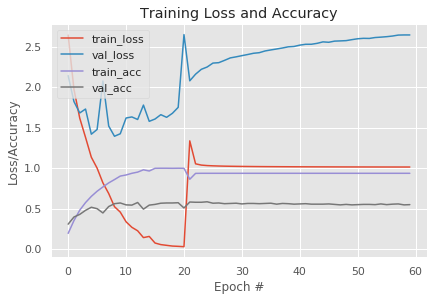

In [0]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 60), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 60), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 60), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 60), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


**PART A : 1**

**First CNN Variant by adding 2 CNN layers**

In [0]:
tf.reset_default_graph()

In [0]:
def firstCNNVariant(width, height, depth, classes):
  
  # initialize the model along with the input shape
  model1 = Sequential()
  inputShape = (height, width, depth)
  # first set of CONV => RELU => POOL layers
  model1.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  # second set of CONV => RELU => POOL layers
  model1.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  # first (and only) set of FC => RELU layers
  model1.add(Flatten())
  model1.add(Dense(500, activation='relu'))
  # softmaxclassifier
  model1.add(Dense(classes, activation='softmax'))
     
  return model1

In [0]:
# initialize the optimizer and model
from keras import backend as K
print("Compiling model...")

#opt = tf.keras.optimizers.SGD(lr=0.01)
opt = SGD(lr = 0.01)
model1 = firstCNNVariant(width=128, height=128, depth=3, classes=17)
print (model1.summary())

model1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H1 = model1.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=1)

Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               32768500  
_________________________________________________________________
dense_4 (Dense)              (None, 17)                85

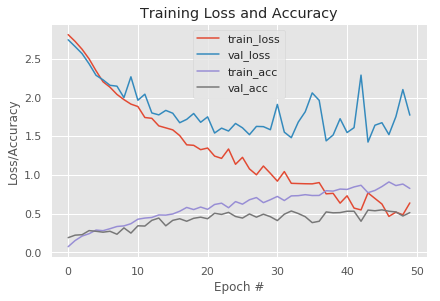

In [0]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H1.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**PART A : 1**

**Second variant of CNN : Increasing the density of each CNN layer by adding 2 CNN layers**

In [0]:
def SecondCNNVariant(width, height, depth, classes):
  
  # initialize the model along with the input shape
  model2 = tf.keras.Sequential()
  inputShape = (height, width, depth)
#   # first set of CONV => RELU => POOL layers
#   model2.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # second set of CONV => RELU => POOL layers
#   model2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # third set of CONV => RELU => POOL layers
#   model2.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # first (and only) set of FC => RELU layers
#   model2.add(Flatten())
#   model2.add(Dense(500, activation='relu'))
#   # softmaxclassifier
#   model2.add(Dense(classes, activation='softmax'))
  
  # first CONV => CONV => POOL layer set
  model2.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
  model2.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
  model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  # second CONV => CONV => POOL layer set
  model2.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
  model2.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
  model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  # first (and only) set of FC => RELU layers
  model2.add(tf.keras.layers.Flatten())
  model2.add(tf.keras.layers.Dense(512,activation='relu'))
  # softmaxclassifier
  model2.add(tf.keras.layers.Dense(classes, activation='softmax'))
     
  return model2

In [0]:
# initialize the optimizer and model

print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
#opt = SGD(lr = 0.01)
model2 = SecondCNNVariant(width=128, height=128, depth=3, classes=17)
print (model2.summary())

model2.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H2 = model2.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=1)

Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0 

**Performing data augmentation**

In [0]:
le=LabelEncoder()
Y=le.fit_transform(trainY)
Y=to_categorical(Y,17)


**PART A : 2**

**We are now going to perform data augmentations and check the impact of it we build in the first part**

**CNN baseline model with single CNN layer**

**Data Augmentation with the below mentioned configuration**

**Configuration 1**

In [0]:
#Construct the image generator for data augmentation

datagen1 = ImageDataGenerator(
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        )

datagen1.fit(trainX)
datagen1.fit(testX)

**Configuration 2**

In [0]:
#Construct the image generator for data augmentation

datagen2 = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        horizontal_flip=True,  # randomly flip images
        )


datagen2.fit(trainX)
datagen2.fit(testX)

**Configuration 3**

In [1]:
#Construct the image generator for data augmentation

datagen4 = ImageDataGenerator(
        shear_range = 0.2,
        zoom_range = 0.2,
        rotation_range = 30,
        horizontal_flip = True,
        vertical_flip = True
        )  


datagen4.fit(trainX)
datagen4.fit(testX)

NameError: ignored

**Configuration 4**

In [0]:
#Construct the image generator for data augmentation

datagen3 = ImageDataGenerator(
        zca_whitening=True,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.4, # Randomly zoom image 
        vertical_flip=True)  # randomly flip images


datagen3.fit(trainX)
datagen3.fit(testX)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
# def fourthCNNVariant(width, height, depth, classes):
  
#   # initialize the model along with the input shape
#   model3 = tf.keras.Sequential()
#   inputShape = (height, width, depth)
#   # first set of CONV => RELU => POOL layers
#   model2.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # second set of CONV => RELU => POOL layers
#   model2.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # third set of CONV => RELU => POOL layers
#   model2.add(Conv2D(96, (3, 3), padding="same", activation='relu'))
#   model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # first (and only) set of FC => RELU layers
#   model2.add(Flatten())
#   model2.add(Dense(500, activation='relu'))
#   # softmaxclassifier
#   model2.add(Dense(classes, activation='softmax'))
  
#   # first CONV => CONV => POOL layer set
#   model3.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=inputShape, activation='relu'))
#   model3.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same",activation='relu'))
#   model3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # second CONV => CONV => POOL layer set
#   model3.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
#   model3.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same",activation='relu'))
#   model3.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#   # first (and only) set of FC => RELU layers
#   model3.add(tf.keras.layers.Flatten())
#   model3.add(tf.keras.layers.Dense(512,activation='relu'))
#   # softmaxclassifier
#   model3.add(tf.keras.layers.Dense(classes, activation='softmax'))
     
#   return model3

In [15]:
# initialize the optimizer and model

print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
#opt = SGD(lr = 0.01)
model = singleCNN(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H3 = model.fit_generator(datagen1.flow(trainX,trainY, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(testX,testY, batch_size=batch_size),
                              verbose = 1, steps_per_epoch=trainX.shape[0] // batch_size, validation_steps = testX.shape[0] //batch_size)

Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0 

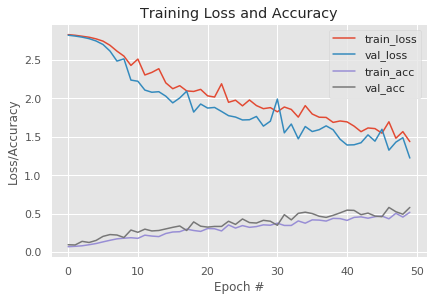

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H3.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H3.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H3.history["acc"], label="train_acc")
plt.plot(np.arange(0, 50), H3.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [0]:
# initialize the optimizer and model

print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
#opt = SGD(lr = 0.01)
model = singleCNN(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H4 = model.fit_generator(datagen2.flow(trainX,trainY, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(testX,testY, batch_size=batch_size),
                              verbose = 1, steps_per_epoch=trainX.shape[0] // batch_size, validation_steps = testX.shape[0] //batch_size)

In [0]:
# initialize the optimizer and model

print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
#opt = SGD(lr = 0.01)
model = singleCNN(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H5 = model.fit_generator(datagen3.flow(trainX,trainY, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(testX,testY, batch_size=batch_size),
                              verbose = 1, steps_per_epoch=trainX.shape[0] // batch_size, validation_steps = testX.shape[0] //batch_size)

In [0]:
# initialize the optimizer and model

print("Compiling model...")

opt = tf.keras.optimizers.SGD(lr=0.01)
#opt = SGD(lr = 0.01)
model = singleCNN(width=128, height=128, depth=3, classes=17)
print (model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("Training network...")
H3 = model.fit_generator(datagen4.flow(trainX,trainY, batch_size=batch_size),
                              epochs = epochs, validation_data = datagen.flow(testX,testY, batch_size=batch_size),
                              verbose = 1, steps_per_epoch=trainX.shape[0] // batch_size, validation_steps = testX.shape[0] //batch_size)

**Ensemble method**

In [0]:
# Predict labels with models
labels = []
for m in models:
    predicts = np.argmax(m.predict(testY), axis=1)
    labels.append(predicts)
    
# Ensemble with voting
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
labels = scipy.stats.mode(labels, axis=-1)[0]
labels = np.squeeze(labels)